In [1]:
!mkdir Hackathon
!cp -r /content/drive/MyDrive/Hackathon/mod-hushem /content/Hackathon
#!cp -r /content/drive/MyDrive/Hackathon/models /content/Hackathon

Load data (hushem).

In [32]:
import h5py
import numpy as np
import os
from random import seed, random
from PIL import Image
import matplotlib.pyplot as plt

seed(121)
base_path = './Hackathon/mod-hushem'  # dataset path
img_path = 'images'  # new dataset path

image_ids = []
annotators = []
pathologies = []
images = []
data_split = []
pathology = 0
for i in os.listdir(base_path):
  print(i)
  pathology_path = os.path.join(base_path, i)
  for j in os.listdir(pathology_path):
    id = i + '/' + j[:-4]
    annotator = j[-5:-4]
    image_ids.append(id)
    annotators.append(int(annotator))
    pathologies.append(pathology)
    img = Image.open(os.path.join(pathology_path, j))
    img = img.resize((131, 131), Image.ANTIALIAS)
    images.append(np.array(img))
    sort_num = random()
    if (sort_num > 0.80):
      data_split.append(1)
    elif (sort_num > 0.70):
      data_split.append(2)
    else:
      data_split.append(0)
  pathology += 1

images = np.asarray(images)
annotators = np.asarray(annotators)
pathologies = np.asarray(pathologies)
image_ids = np.asarray(image_ids)
data_split = np.asarray(data_split)
print(images.shape)

normal
pyriform
tapered
amorphous
(216, 131, 131, 3)


Update data_split according to csv file.

In [33]:
import csv
with open('file.csv', newline='') as csvfile:
  reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
  first_line = True
  for row in reader:
    if first_line:
      first_line = False
    else:
      split_row = row[0].split(',')
      index = np.where(image_ids == split_row[0])[0]
      data_split[index] = int(split_row[-1])

Write data to file.


In [ ]:
import csv
file = open("file.csv", "w")
writer = csv.writer(file)

writer.writerow(['img', 'annotator', 'label', 'split'])

for w in range(len(images)):
  writer.writerow([image_ids[w], annotators[w], pathologies[w], data_split[w]])

file.close()

Model definition.

In [41]:
import tensorflow as tf
import matplotlib.pyplot as plt

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./127.5, offset=-1),
  tf.keras.layers.Resizing(128, 128)
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    #rotation_range=30,
    width_shift_range=0.10,
    height_shift_range=0.10,
    #horizontal_flip=True,
)

def build_model():
  #base_model = tf.keras.applications.MobileNetV2(input_shape=(131, 131, 3), include_top=False, weights=None)
  #head_model = base_model.output
  model_input = tf.keras.layers.Input(shape=(128, 128, 3))
  base_model = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu")(model_input)
  base_model = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(base_model)
  base_model = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(base_model)
  base_model = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(base_model)
  base_model = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(base_model)
  base_model = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(base_model)
  head_model = tf.keras.layers.GlobalAveragePooling2D()(base_model)
  head_model = tf.keras.layers.Dense(64, activation="relu")(head_model)
  head_model = tf.keras.layers.Dropout(0.5)(head_model)
  head_model = tf.keras.layers.Dense(4, activation="softmax")(head_model)
  model = tf.keras.models.Model(inputs=model_input, outputs=head_model)
  model.summary()
  model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-3),
    metrics=['accuracy'])
  return model

In [42]:
!rm -rf models

Data augmentation

In [36]:
augmented_images = []
augmented_annotators = []
augmented_labels = []
augmented_split = []

images = np.array(resize_and_rescale(images))

for i in range(0, len(images)-1):
  it = data_generator.flow(np.asarray([images[0]]), batch_size=1)
  augmented_images.append(images[i])
  augmented_annotators.append(annotators[i])
  augmented_labels.append(pathologies[i])
  augmented_split.append(data_split[i])
  for _ in range(5):
    augmented_image = data_augmentation(images[i])
    augmented_annotators.append(annotators[i])
    augmented_labels.append(pathologies[i])
    augmented_split.append(data_split[i])
    augmented_images.append(augmented_image)
  for _ in range(5):
    augmented_image = np.asarray(it.next())[0]
    augmented_annotators.append(annotators[i])
    augmented_labels.append(pathologies[i])
    augmented_split.append(data_split[i])
    augmented_images.append(augmented_image)


augmented_images = np.asarray(augmented_images)
augmented_annotators = np.asarray(augmented_annotators)
augmented_labels = np.asarray(augmented_labels)
augmented_split = np.asarray(augmented_split)
print(augmented_images.shape)

(2365, 128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

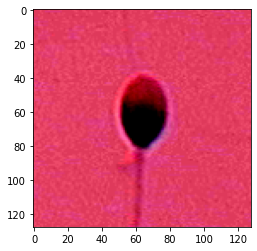

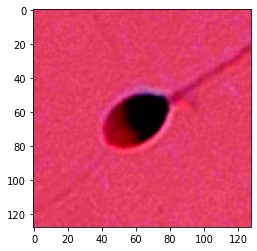

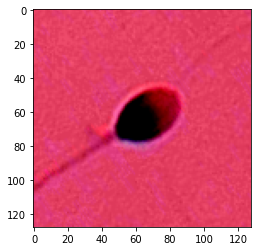

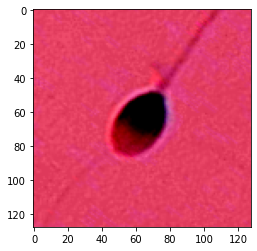

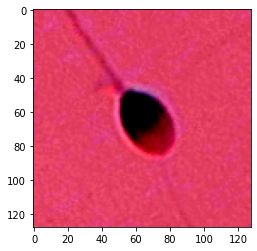

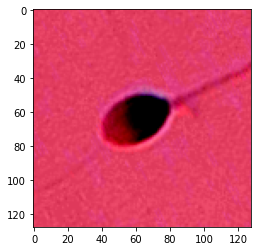

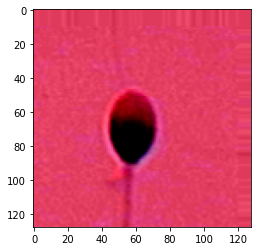

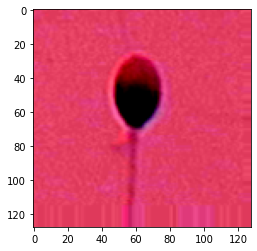

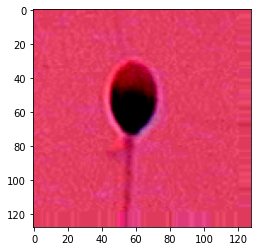

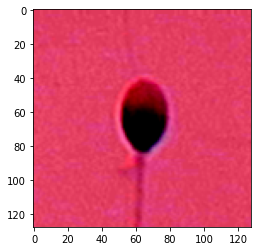

In [37]:
import matplotlib.pyplot as plt

for i in range(0, 10):
  plt.figure()
  plt.imshow(augmented_images[i])

In [24]:
!rm -rf models

Model training.

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 14, 14, 64)        0  

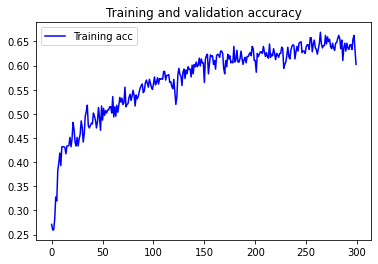

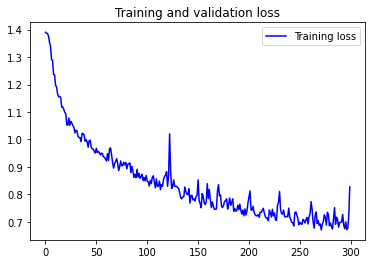

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 14, 14, 64)        0  

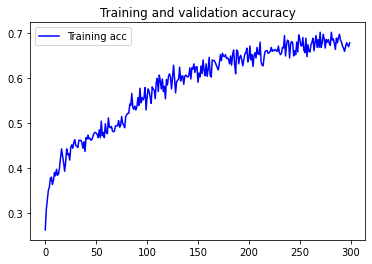

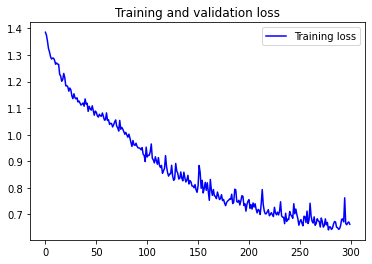

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 14, 14, 64)        0  

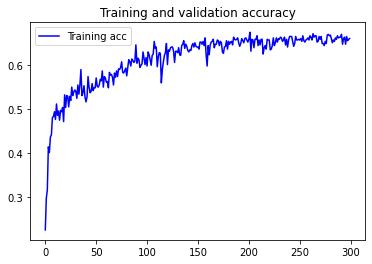

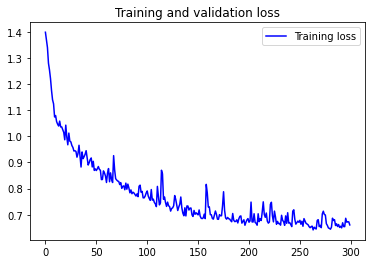

In [43]:
import matplotlib.pyplot as plt

#images = np.array(resize_and_rescale(images))
#cat_pathologies = pathologies
cat_pathologies = tf.keras.utils.to_categorical(augmented_labels, 4)

train_index = np.where(augmented_split == 0)[0]
valid_index = np.where(augmented_split == 2)[0]
train_index = np.append(train_index, valid_index)
test_index = np.where(augmented_split == 1)[0]

train_images = augmented_images[train_index]
valid_images = augmented_images[valid_index]
test_images = augmented_images[test_index]


def train_model(ann):
  annotator = build_model()
  ann_index = np.where(augmented_annotators == ann)[0]

  train_images = augmented_images[np.intersect1d(train_index, ann_index)]
  train_class = cat_pathologies[np.intersect1d(train_index, ann_index)]
  #valid_images = images[np.intersect1d(valid_index, ann_index)]
  #print(valid_images.shape)
  #valid_class = cat_pathologies[np.intersect1d(valid_index, ann_index)]

  epochs = 300
  checkpoint = tf.keras.callbacks.ModelCheckpoint('models/annotator' + str(ann) + '-model_{epoch:03d}.h5', 
    monitor='loss', verbose=1, save_best_only=True,  mode='min', save_freq='epoch')
  #early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min')

  history = annotator.fit(
    train_images, train_class,
    batch_size=16,
    epochs=epochs,
    callbacks=[checkpoint],
    verbose=1)
  
  acc = history.history['accuracy']
  loss = history.history['loss']

  epochs = range(len(acc))
  plt.plot(epochs, acc, 'b', label='Training acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  return annotator

annotator1 = train_model(1)
annotator2 = train_model(2)
annotator3 = train_model(3)

In [30]:
import tensorflow as tf
annotator1 = tf.keras.models.load_model('./annotator1-model_296.h5')
annotator2 = tf.keras.models.load_model('./annotator2-model_297.h5')
annotator3 = tf.keras.models.load_model('./annotator3-model_296.h5')

In [49]:
from sklearn.metrics import classification_report, confusion_matrix

#images = np.array(resize_and_rescale(images))
#test_index = np.where(augmented_split == 1)[0]
test_index = np.where(data_split == 1)[0]

def test_models(ann, model):
  #ann_index = np.where(augmented_annotators == ann)[0]
  #test_images = augmented_images[np.intersect1d(test_index, ann_index)]
  #c_pathologies = tf.keras.utils.to_categorical(augmented_labels, 4)
  ann_index = np.where(annotators == ann)[0]
  test_images = images[np.intersect1d(test_index, ann_index)]
  c_pathologies = tf.keras.utils.to_categorical(pathologies, 4)
  
  test_class = c_pathologies[np.intersect1d(test_index, ann_index)]
  results_ann = model.evaluate(test_images, test_class)
  print(results_ann)

  test_class2 = pathologies[np.intersect1d(test_index, ann_index)]
  #test_class2 = augmented_labels[np.intersect1d(test_index, ann_index)]
  predIdxs = model.predict(test_images)
  predIdxs = np.argmax(predIdxs, axis=1)
  print(classification_report(test_class2, predIdxs))
  print(confusion_matrix(test_class2, predIdxs))

test_models(1, annotator1)
test_models(2, annotator2)
test_models(3, annotator3)

1/1 [==============================] - 0s 27ms/step - loss: 7.3701 - accuracy: 0.6429
[7.370112419128418, 0.6428571343421936]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.43      0.75      0.55         4
           2       0.00      0.00      0.00         4
           3       0.67      1.00      0.80         2

    accuracy                           0.64        14
   macro avg       0.52      0.69      0.59        14
weighted avg       0.50      0.64      0.56        14

[[4 0 0 0]
 [0 3 0 1]
 [0 4 0 0]
 [0 0 0 2]]
1/1 [==============================] - 0s 27ms/step - loss: 3.5034 - accuracy: 0.6000
[3.5033531188964844, 0.6000000238418579]
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.00      0.00      0.00         1
           2       0.50      0.33      0.40         3
           3       1.00      1.00      1.00       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 26ms/step - loss: 5.5869 - accuracy: 0.6250
[5.5868754386901855, 0.625]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.40      0.57         5
           2       0.60      0.60      0.60         5
           3       0.50      0.50      0.50         2

    accuracy                           0.62        16
   macro avg       0.67      0.62      0.60        16
weighted avg       0.71      0.62      0.61        16

[[4 0 0 0]
 [0 2 2 1]
 [2 0 3 0]
 [1 0 0 1]]


In [48]:
from sklearn.metrics import cohen_kappa_score

#test_index = np.where(augmented_split == 1)[0]
#result1 = annotator1.predict(augmented_images[test_index])
#result2 = annotator2.predict(augmented_images[test_index])
#result3 = annotator3.predict(augmented_images[test_index])

test_index = np.where(data_split == 1)[0]
result1 = annotator1.predict(images[test_index])
result2 = annotator2.predict(images[test_index])
result3 = annotator3.predict(images[test_index])

result1 = np.argmax(result1, axis=1)
result2 = np.argmax(result2, axis=1)
result3 = np.argmax(result3, axis=1)

majority_vote = []
for res in range(0, len(result1)):
  if result1[res] == result2[res] or result1[res] == result3[res]:
    majority_vote.append(result1[res])
  else:
    majority_vote.append(result2[res])


print('Cohen Kappa Score:')
print('Annotator 1:' + str(cohen_kappa_score(result1, majority_vote)))
print('Annotator 2:' + str(cohen_kappa_score(result2, majority_vote)))
print('Annotator 3:' + str(cohen_kappa_score(result3, majority_vote)))

failures = np.where(result1 == majority_vote)[0].shape[0]
print('\nPercentage of failures:')
print('Annotator 1:' + str(np.where(result1 != majority_vote)[0].shape[0] / len(result1)))
print('Annotator 2:' + str(np.where(result2 != majority_vote)[0].shape[0] / len(result1)))
print('Annotator 3:' + str(np.where(result3 != majority_vote)[0].shape[0] / len(result1)))

Cohen Kappa Score:
Annotator 1:0.5213675213675213
Annotator 2:0.7276595744680852
Annotator 3:0.7217391304347827

Percentage of failures:
Annotator 1:0.35
Annotator 2:0.2
Annotator 3:0.2


Load data (mhsma).

In [ ]:
import h5py
import numpy as np
import os
from random import seed, random
from PIL import Image
import matplotlib.pyplot as plt

seed(123)
base_path = './Hackathon/Hackathon/mod-mhsma'  # dataset path
img_path = 'images'  # new dataset path

image_ids = []
annotators = []
pathologies = []
images = []
data_split = []
'''
print(sorted(os.listdir(base_path)))
for i in sorted(os.listdir(base_path)):
  if i[-3:] != 'png':
    continue
  print(i)
  id = i[:-4]
  annotator = i[-5:-4]
  image_ids.append(id)
  annotators.append(int(annotator))
  img = Image.open(os.path.join(base_path, i))
  #print(np.array(img).shape)
  #img = img.resize((131, 131), Image.ANTIALIAS)
  images.append(np.array(img))
  sort_num = random()
  if (sort_num > 0.80):
    data_split.append(1)
  elif (sort_num > 0.70):
    data_split.append(2)
  else:
    data_split.append(0)
'''

f1 = open(base_path + "/labels/labels_acr.txt", "r")
f2 = open(base_path + "/labels/labels_head.txt", "r")
f3 = open(base_path + "/labels/labels_tail.txt", "r")
f4 = open(base_path + "/labels/labels_vac.txt", "r")
res1 = f1.read()[2:-2]
res2 = f2.read()[2:-2]
res3 = f3.read()[2:-2]
res4 = f4.read()[2:-2]
res1 = res1.split(',')
res2 = res2.split(',')
res3 = res3.split(',')
res4 = res4.split(',')
for i in range(len(res1)-1):
  print(i)
  pathologies.append(res1[i])#[int(res1[i]), int(res2[i]), int(res3[i]), int(res4[i])])
  for img_n in sorted(os.listdir(base_path)):
    if img_n[-3:] != 'png':
      continue

    if int(img_n.split('_')[1]) == i+1:
      id = img_n[:-4]
      annotator = img_n[-5:-4]
      image_ids.append(id)
      annotators.append(int(annotator))
      img = Image.open(os.path.join(base_path, img_n))
      images.append(np.array(img))
      sort_num = random()
      if (sort_num > 0.80):
        data_split.append(1)
      elif (sort_num > 0.70):
        data_split.append(2)
      else:
        data_split.append(0)


images = np.asarray(images)
annotators = np.asarray(annotators)
pathologies = np.asarray(pathologies)
image_ids = np.asarray(image_ids)
data_split = np.asarray(data_split)
print(images.shape)
